# Predicting Media Memorability: MediaEval 2018

[MediaEval](http://www.multimediaeval.org) is Benchmarking Initiative for Multimedia Evaluation. Every year they organize competetions with new datasets and Machine learning tasks. Predicting video memorability is one of the tasks in 2018.

**Task description:** Participants are expected to build systems that are capable of predicting how memorable a video is, by computing for each video a memorability score.


Reference: http://ceur-ws.org/Vol-2283/MediaEval_18_paper_1.pdf
<a id='contact_details'></a>

**Contact Information: &nbsp;**If you have any questions in running this script, Below is my contact details:

<font color='blue'>Email ID: &nbsp;</font> salman.khaleelsab2@mail.dcu.ie

# How this Notebook is divided?

This notebook is organized as follows:

* **SECTION 1 &nbsp;  :** [Function Definitions](#section1)


* **SECTION 2 &nbsp;  :** [Loading Features](#section2)


* **SECTION 3 &nbsp;  :** [Data Preprocessing](#section3)


* **SECTION 4 &nbsp;  :** [Experiments with different Machine Learning models and features/combinations](#section4)
  * Section 4.1: [Random Forest with Captions](#section4.1)
  * Section 4.2: [SVR with Captions](#section4.2)
  * Section 4.3: [Random Forest with C3D](#section4.3)
  * Section 4.4: [SVR with C3D](#section4.4)
  * Section 4.5: [Random Forest with Captions+C3D](#section4.5)
  * Section 4.6: [SVR with Captions+C3D](#section4.6)
  * Section 4.7: [Random Forest with Captions+C3D+HMP](#section4.7)
  * Section 4.8: [SVR with Captions+C3D+HMP](#section4.8)
  
  
* **SECTION 5 &nbsp;  :** [Selecting the best model with features](#section5)


* **SECTION 6 &nbsp;  :** [Predicting the Memorability scores on Test-Set](#section7)
  * Section 6.1:  [Training full 6000 Dev-Set](#section7.1)
  * Section 6.2:  [Importing Test Datasets and Captions](#section7.2)
  * Section 6.3:  [Predicting the Scores and Exporting the Results](#section7.3)

<font color='blue'>* Click on the links to jump directly to desired sections *</font>

#### Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import glob
import nltk

<a id='section1'></a>

## SECTION 1&nbsp;:  FUNCTIONS DEFINITION

Here we are defining necessary functions required.

In [3]:
#Function to load C3D features
def load_c3d(captions, c3dPath):
    files = list(captions["video"].values)
    c3dfeatures = []
    for file in files:
        file = c3dPath+file[:-4]+'txt'
        c3dfeatures.append(np.loadtxt(file))
    #print(type(c3dfeatures))
    return c3dfeatures

In [4]:
#Function to load HMP features
def load_hmp(captions, hmp_path):
    files = list(captions["video"].values)
    hmp_features = []
    for file in files:
        file = hmp_path+file[:-4]+'txt'
        with open(file) as f:
            for line in f:
                pairs=line.split()
                HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
                HMP = np.zeros(6075)
            for idx in HMP_temp.keys():
                HMP[idx-1] = HMP_temp[idx]
            hmp_features.append(HMP)
    return hmp_features

In [5]:
#Function to load the captions into dataframes
def load_captions(filename):
    video_name = []
    captions = []
    dataframe = pd.DataFrame()
    with open(filename) as file:
        for line in file:
            pair = line.split() #each line in the text file contains to words so, this code will split them into two words
            video_name.append(pair[0]) #first word will be assigned as video name
            captions.append(pair[1]) #second word will be assigned as caption
        dataframe['video']=video_name #setting these two as column names of dataframe
        dataframe['caption']=captions
    return dataframe

In [6]:
#Function to calculate Spearman coefficient scores
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

<a id='section2'></a>

## SECTION 2&nbsp;:  LOADING FEATURES

<font color='red'> **IMPORTANT NOTE:** </font>&nbsp; Below lines of code is completely dependent on where you are running this script. I have downloaded complete datset and features to my local machine. So, this path is local to my system

If you are using **Google Colab**, Please change the path according to your machine.

Please contact me if you are not able to run this script. [Contact details](#contact_details) are provided above.

In [160]:
#load the ground truth dataset
csv_path ='/Users/salmank/Downloads/Dataset/dev-set_ground-truth.csv'
dataset = pd.read_csv(csv_path)

#load captions
captions_path ='/Users/salmank/Downloads/Dataset/dev-set_video-captions.txt'
captions = load_captions(captions_path)


#load C3D features
c3dPath = '/Users/salmank/Downloads/Given/dev-set/dev-set_features/C3D/'
c3dfeatures = load_c3d(captions,c3dPath)

#load HMP features
hmp_path = '/Users/salmank/Downloads/Given/dev-set/dev-set_features/HMP/'
hmp_features = load_hmp(captions,hmp_path)

In [80]:
dataset.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


In [161]:
captions.head()

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot


In [83]:
#(c3dfeatures)

In [84]:
#(hmp_features)

In [162]:
#shape of the dataframes
print(f'Ground Truth : {dataset.shape}')
print(f'Dev Captions : {dev_captions.shape}')
print(f'C3D          : ({len(c3dfeatures)})')
print(f'HMP          : ({len(hmp_features)})')

Ground Truth : (6000, 5)
Dev Captions : (6000, 2)
C3D          : (6000)
HMP          : (6000)


***
<a id='section3'></a>

## SECTION 3: DATA PREPROCESSING

**Captions: Bag of words CountVectorizer**

We have loaded both Development set Captions and Test set Captions in two seperate variables. I will be combining both of these to a single variable and implement CountVectorizer.

The reaseon behind this is, initially both were seperately vectorized and later we faced dimensions issues when trying to predict the test set scores.

For training I will be using only first 6000 captions by splitting and rest 2000 will be used for prediction.

In [93]:
#loading the nltk stopwords of English
stopwords = nltk.corpus.stopwords.words('english')
print(f'Length of Stopwords: {len(stopwords)}')

Length of Stopwords: 179


Cleaning Development set Captions

In [163]:
#Removing punctuations and stop words from captions
# setup prograss tracker
pbar = pyprind.ProgBar(len(captions['caption']), title='Counting word occurrences')
for i, cap in enumerate(captions['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    #removing stopwords
    rmv_stopwords= ' '.join([word for word in text.split() if word not in stopwords])
    captions.loc[i,'caption'] = rmv_stopwords #updating the original captions 
    pbar.update()

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


In [164]:
captions.head()

,video,caption
0,video3.webm,blonde woman massaged tilt
1,video4.webm,roulette table spinning ball closeup shot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hovers airport
4,video10.webm,couple relaxing picnic crane shot


In [185]:
#implementing bag of words for the combined captions
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",max_features=3112) 
captions_bag = vectorizer.fit_transform(captions.caption).toarray()
type(captions_bag)

numpy.ndarray

In [186]:
captions_bag.shape

(6000, 3112)

**Combining Captions and C3D into a single Vector**

In [19]:
captions_c3d = (captions_bag.tolist())
counter = 0
for item in range(6000):
    captions_c3d[counter] = np.append(captions_c3d[counter],c3dfeatures[counter],axis=0)
    counter = counter+1

In [20]:
len(captions_c3d[0]) 

5188

In [21]:
len(captions_c3d)

6000

**Combining Captions+C3D+HMP**

In [22]:
#Combining captions_c3d with HMP to form 
captions_c3d_hmp = captions_c3d
counter = 0
for item in range(6000):
    captions_c3d_hmp[counter] = np.append(captions_c3d_hmp[counter],hmp_features[counter],axis=0)
    counter = counter+1

In [23]:
len(captions_c3d_hmp[0]) 

11263

In [41]:
len(captions_c3d_hmp)

6000

Now we have the following features

1.   Captions in: captions_bag
2.   C3D in: c3dfeatures 
3.   HMP in: hmp_features
4.   Captions and C3D:&nbsp;  captions_c3d
5.   Captions, C3D and HMP in: captions_c3d_hmp

***
<a id='section4'></a>

## SECTION 4: &nbsp; EXPERIMEMTS WITH DIFFERENT MACHINE LEARNING MODELS AND FEATURES/COMBINATIONS <a id='section4.1'></a>

### Section 4.1: &nbsp; Random Forest  with Captions

In [130]:
X = captions_bag
y = dataset[['short-term_memorability','long-term_memorability']].values

In [131]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [132]:
print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', y_train.shape)
print('Y_test  ', y_test.shape)

X_train  (4800, 5762)
X_test   (1200, 5762)
Y_train  (4800, 2)
Y_test   (1200, 2)


In [133]:
from sklearn.ensemble import RandomForestRegressor
captions_rf = RandomForestRegressor(n_estimators=100,random_state=45)

In [134]:
captions_rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=45, verbose=0, warm_start=False)

In [135]:
captions_pred = captions_rf.predict(X_test)

In [136]:
Get_score(captions_pred, y_test)

The Spearman's correlation coefficient is: 0.416
The Spearman's correlation coefficient is: 0.179


***

### Section 4.2: &nbsp;  SVR with Captions

In [26]:
svr_X = captions_bag
svr_y_short = dataset[['short-term_memorability']].values
svr_y_long = dataset[['long-term_memorability']].values

In [27]:
# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(svr_X,svr_y_short,test_size=0.2,random_state=40)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(svr_X,svr_y_long,test_size=0.2,random_state=40)

In [28]:
from sklearn.preprocessing import StandardScaler
short_X = StandardScaler()
short_y = StandardScaler()
short_X_train = short_X.fit_transform(short_X_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_X_train = long_X.fit_transform(long_X_train)
long_y_train = long_y.fit_transform(long_y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [29]:
from sklearn.svm import SVR
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_X_train, short_y_train)
long_regressor.fit(long_X_train,long_y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
short_pred = short_regressor.predict(short_X_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_X_test)
long_pred = long_y.inverse_transform(long_pred)

In [31]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.355
The Spearman's correlation coefficient is: 0.171


***
<a id='section4.3'></a>

### Section 4.3: &nbsp; Random Forest with C3D

In [35]:
X = c3dfeatures
y = dataset[['short-term_memorability','long-term_memorability']].values

In [36]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [37]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=20,random_state=42,verbose=2)

In [38]:
rf_regressor.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.2s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=42, verbose=2, warm_start=False)

In [39]:
rf_pred = rf_regressor.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [40]:
Get_score(rf_pred, y_test)

The Spearman's correlation coefficient is: 0.266
The Spearman's correlation coefficient is: 0.122


***
<a id='section4.4'></a>

### Section 4.4: &nbsp;  SVR with C3D

In [41]:
svr_X = c3dfeatures
svr_y_short = dataset[['short-term_memorability']].values
svr_y_long = dataset[['long-term_memorability']].values

In [42]:
# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(svr_X,svr_y_short,test_size=0.2,random_state=40)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(svr_X,svr_y_long,test_size=0.2,random_state=40)

In [43]:
from sklearn.preprocessing import StandardScaler
short_X = StandardScaler()
short_y = StandardScaler()
short_X_train = short_X.fit_transform(short_X_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_X_train = long_X.fit_transform(long_X_train)
long_y_train = long_y.fit_transform(long_y_train)

In [44]:
from sklearn.svm import SVR
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_X_train, short_y_train)
long_regressor.fit(long_X_train,long_y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [45]:
short_pred = short_regressor.predict(short_X_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_X_test)
long_pred = long_y.inverse_transform(long_pred)

In [46]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.242
The Spearman's correlation coefficient is: 0.107


***
<a id='section4.5'></a>

### Section 4.5: &nbsp; Random Forest with Captions and C3D

In [47]:
X = captions_c3d
y = dataset[['short-term_memorability','long-term_memorability']].values

In [48]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [49]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=50,random_state=45,verbose=2)

In [50]:
rf_regressor.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 19.6min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=45, verbose=2, warm_start=False)

In [51]:
rf_pred = rf_regressor.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [52]:
Get_score(rf_pred, y_test)

The Spearman's correlation coefficient is: 0.321
The Spearman's correlation coefficient is: 0.104


***
<a id='section4.6'></a>

### Section 4.6: &nbsp; SVR with Captions and C3D

In [53]:
svr_X = captions_c3d
svr_y_short = dataset[['short-term_memorability']].values
svr_y_long = dataset[['long-term_memorability']].values

In [54]:
# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(svr_X,svr_y_short,test_size=0.2,random_state=40)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(svr_X,svr_y_long,test_size=0.2,random_state=40)

In [55]:
from sklearn.preprocessing import StandardScaler
short_X = StandardScaler()
short_y = StandardScaler()
short_X_train = short_X.fit_transform(short_X_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_X_train = long_X.fit_transform(long_X_train)
long_y_train = long_y.fit_transform(long_y_train)

In [56]:
from sklearn.svm import SVR
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_X_train, short_y_train)
long_regressor.fit(long_X_train,long_y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [57]:
short_pred = short_regressor.predict(short_X_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_X_test)
long_pred = long_y.inverse_transform(long_pred)

In [58]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.366
The Spearman's correlation coefficient is: 0.180


***
<a id='section4.7'></a>

### Section 4.7: &nbsp; Random Forest with Captions, C3D and HMP

In [59]:
X = captions_c3d_hmp
y = dataset[['short-term_memorability','long-term_memorability']].values

In [60]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [61]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100,random_state=45,verbose=2)

In [62]:
rf_regressor.fit(X_train,y_train)

building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 22.4min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=45, verbose=2, warm_start=False)

In [63]:
rf_pred = rf_regressor.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [64]:
Get_score(rf_pred, y_test)

The Spearman's correlation coefficient is: 0.342
The Spearman's correlation coefficient is: 0.127


***
<a id='section4.8'></a>

### Section 4.8: &nbsp; SVR with Captions, C3D and HMP

In [65]:
svr_X = captions_c3d_hmp
svr_y_short = dataset[['short-term_memorability']].values
svr_y_long = dataset[['long-term_memorability']].values

In [66]:
# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(svr_X,svr_y_short,test_size=0.2,random_state=40)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(svr_X,svr_y_long,test_size=0.2,random_state=40)

In [67]:
from sklearn.preprocessing import StandardScaler
short_X = StandardScaler()
short_y = StandardScaler()
short_X_train = short_X.fit_transform(short_X_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_X_train = long_X.fit_transform(long_X_train)
long_y_train = long_y.fit_transform(long_y_train)

In [68]:
from sklearn.svm import SVR
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_X_train, short_y_train)
long_regressor.fit(long_X_train,long_y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [69]:
short_pred = short_regressor.predict(short_X_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_X_test)
long_pred = long_y.inverse_transform(long_pred)

In [70]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.366
The Spearman's correlation coefficient is: 0.180


***
<a id='section5'></a>

# SECTION 5:  SELECTING THE BEST MODEL WITH FEATURES

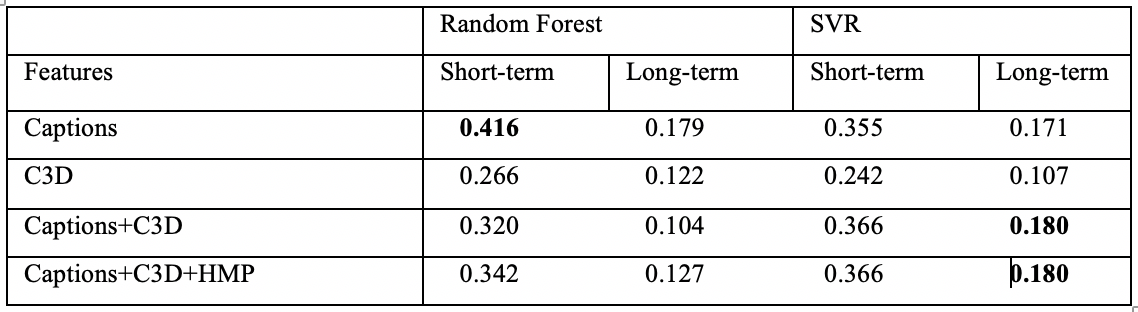

In [142]:
from IPython.display import Image
Image(filename="table.png",width="500",height="300")

Above Table shows the Spearman's coefficient corelation scores obtained with different features/combinations. 

From the results, It is notable that Captions yielded the best performance with Random Forest model

In [144]:
Get_score(captions_pred, y_test)

The Spearman's correlation coefficient is: 0.416
The Spearman's correlation coefficient is: 0.179


***
<a id='section7'></a>

# SECTION 6: &nbsp; PRDICTING THE TEST RESULTS

In the above [Random Forest with Captions](#section4.1) model, We had divided our development dataset for training and testing. In order to predict the test results, we need to train our model for full 6000 Development dataset. 

In the Below lines of code, we will be using full 6000 records of development datatset to train our model and predict the scores on testing set which has 2000 records.
<a id='section7.1'></a>

### Section 6.1: &nbsp; Training full 6000 Dev-Set

In [189]:
X = captions_bag
y = dataset[['short-term_memorability','long-term_memorability']].values

In [190]:
print(f'X: ({len(X)})')
print(f'y:{y.shape}')

X: (6000)
y:(6000, 2)


In [191]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100,random_state=45)

In [192]:
rf_regressor.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=45, verbose=0, warm_start=False)

Now We have trained our model for full 6000 Dev-set.
<a id='section7.2'></a>

<a id='section7.2'></a>

### Section 6.2: &nbsp; Importing Test Dataset and Captions

In [193]:
#importing test Dataset
csv_path ='../Submission/memorability_scores.csv'
test_dataset = pd.read_csv(csv_path)

In [194]:
#load the test set captions
test_captions_path ='/Users/salmank/Documents/SEM2/ML/Assignment/Test-set/test-set-1_video-captions.txt'
test_captions = load_captions(test_captions_path)

In [195]:
test_dataset.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


We need to predict and fill the values of the above Short-term Memorability and Long-term Memorability Scores using our trained model

In [196]:
test_captions.head()

,video,caption
0,video7494.webm,green-jeep-struggling-to-drive-over-huge-rocks
1,video7495.webm,hiking-woman-tourist-is-walking-forward-in-mou...
2,video7496.webm,close-up-of-african-american-doctors-hands-usi...
3,video7497.webm,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,video7498.webm,slow-motion-of-photographer-in-national-park


In [197]:
#printing the dimensions of test-set dataset and features
print(f'Test-Dataset : {test_dataset.shape}')
print(f'Test-Captions: {test_captions.shape}')

Test-Dataset : (2000, 5)
Test-Captions: (2000, 2)


In [198]:
#Removing punctuations and stop words from captions
# setup prograss tracker
pbar = pyprind.ProgBar(len(test_captions['caption']), title='Counting word occurrences')
for i, cap in enumerate(test_captions['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    #removing stopwords
    rmv_stopwords= ' '.join([word for word in text.split() if word not in stopwords])
    test_captions.loc[i,'caption'] = rmv_stopwords #updating the original captions 
    pbar.update()

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [199]:
test_captions.head()

,video,caption
0,video7494.webm,green jeep struggling drive huge rocks
1,video7495.webm,hiking woman tourist walking forward mountains...
2,video7496.webm,close african american doctors hands using sph...
3,video7497.webm,slow motion man using treadmill gym regular ph...
4,video7498.webm,slow motion photographer national park


In [200]:
#implementing bag of words for the combined captions
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",max_features=3122) 
test_captions_bag = vectorizer.fit_transform(test_captions.caption).toarray()
type(test_captions_bag)

numpy.ndarray

In [201]:
#print(f'Testing Bag of words size     : {len(test_captions_bag)}')
#print(f'Development Bag of words size : {len(captions_bag)}')
print(f'Development Vocabulary Size   : {len(captions_bag[0])}')
print(f'Testing Vocabulary Size       : {len(test_captions_bag[0])}')

Development Vocabulary Size   : 3112
Testing Vocabulary Size       : 3112


***
<a id='section7.3'></a>

### Section 6.3: &nbsp; Predicting the scores and Exporting the Results

In [234]:
test_pred = rf_regressor.predict(test_captions_bag)

In [235]:
pred = pd.DataFrame()

In [203]:
type(test_pred)

numpy.ndarray

In [237]:
pred['short-term'] = test_pred[:,0]

In [239]:
pred['long-term'] = test_pred[:,1]

In [240]:
pred.head()

,short-term,long-term
0,0.854635,0.712699
1,0.898883,0.781500
2,0.841901,0.805625
3,0.915282,0.826990
4,0.866134,0.711727


In [243]:
pred.describe()

,short-term,long-term
count,2000.000000,2000.000000
mean,0.848028,0.751163
std,0.034564,0.067863
min,0.687093,0.397318
25%,0.830368,0.721224
50%,0.849698,0.757218
75%,0.871004,0.792872
max,0.953749,0.949478


In [241]:
pred.to_csv("Results.csv",index=False)    

***